<h1 style="text-align: center;">Analysis of Audiobooks</h1>
<h2 style="text-align: center;">Spring 2024 Data Science Project</h2>
<h2 style="text-align: center;">Yixiang Wu</h2>

Member 1: Yixiang Wu, Contribution: 100%

Yixiang Wu: The code and documentation for this project are written entirely by me.

<h1 style="text-align: center;">Introduction</h1>

As the audiobook market has experienced rapid growth recently, this project aims to explore audiobooks and predict their pricing based on different key audiobook features. By knowing predicted audiobook prices, we could understand factors that influence audiobook costs. This helps consumers to make better decisions at purchase, allows authors and narrators to apply better pricing strategies, and lets the industry improve its platform, forecast demand, and adapt to consumer preferences.

<h1 style="text-align: center;">Data Curation</h1>

The data was collected from https://www.audible.com. To accomplish such task, a modified version of the script from https://www.github.com/snehangsude/audible_scraper was used. A dataset gathered via this original script is available at https://www.kaggle.com/datasets/snehangsude/audible-dataset. However, the original script is out-of-date and collects data from Audible in India. I updated the script and allowed it to collect data from Audible in the U.S. The uncleaned data gathered via my script is saved as 'audible_uncleaned.csv' and will be loaded later.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from collections import Counter
from datetime import timedelta
from scipy.stats import pearsonr, ttest_ind
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression, BayesianRidge, ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

from preprocess_and_exploration import data_folder

## Load Dataset

In [2]:
audible_data = pd.read_csv(data_folder + '/audible_uncleaned.csv')
audible_data.head()

,name,author,narrator,time,releasedate,language,stars,price
0,At Home,By: Bill Bryson,Narrated by: Bill Bryson,16 hrs and 33 mins,Release date: 10-05-10,English,"4.5 out of 5 stars6,439 ratings",22.50
1,Preserved,By: Dean G. Lampros,Narrated by: Al Kessel,11 hrs and 10 mins,Release date: 03-26-24,English,Not rated yet,21.49
2,Venice,By: Dennis Romano,Narrated by: David Colacci,30 hrs and 45 mins,Release date: 02-27-24,English,4 out of 5 stars4 ratings,30.09
3,"Elevating Construction Senior Superintendents,...",By: Jason Schroeder,Narrated by: Kate Schroeder,7 hrs and 24 mins,Release date: 03-08-24,English,Not rated yet,14.99
4,Castles,By: Marc Morris,Narrated by: Derek Perkins,9 hrs and 18 mins,Release date: 04-04-17,English,4.5 out of 5 stars64 ratings,15.47


<h1 style="text-align: center;">Data Preprocess</h1>

For data preprocessing, the data frame is examined column by column, extracting valuable data from plain strings and converting them to appropriate data types. For a regression task like predicting pricing, data in numeric formats like Float is preferred. The goal here is to transform the raw data into something we can visualize and analyze in the following sections.

In [3]:
audible_data.rename(columns={'releasedate': 'release date'}, inplace=True)
audible_data.rename(str.title, axis='columns', inplace=True)

In [4]:
audible_data.head()

,Name,Author,Narrator,Time,Release Date,Language,Stars,Price
0,At Home,By: Bill Bryson,Narrated by: Bill Bryson,16 hrs and 33 mins,Release date: 10-05-10,English,"4.5 out of 5 stars6,439 ratings",22.50
1,Preserved,By: Dean G. Lampros,Narrated by: Al Kessel,11 hrs and 10 mins,Release date: 03-26-24,English,Not rated yet,21.49
2,Venice,By: Dennis Romano,Narrated by: David Colacci,30 hrs and 45 mins,Release date: 02-27-24,English,4 out of 5 stars4 ratings,30.09
3,"Elevating Construction Senior Superintendents,...",By: Jason Schroeder,Narrated by: Kate Schroeder,7 hrs and 24 mins,Release date: 03-08-24,English,Not rated yet,14.99
4,Castles,By: Marc Morris,Narrated by: Derek Perkins,9 hrs and 18 mins,Release date: 04-04-17,English,4.5 out of 5 stars64 ratings,15.47


In [5]:
audible_data.describe(include='all')

,Name,Author,Narrator,Time,Release Date,Language,Stars,Price
count,55235,55235,54749,55235,55235,55235,55235,55235
unique,52841,33933,19776,2351,5314,23,6736,1429
top,The Odyssey,By: Barrett Williams,Narrated by: Virtual Voice,4 mins,Release date: 04-21-24,English,Not rated yet,Free
freq,15,467,2823,172,353,52877,9202,11319


In [6]:
audible_data.dtypes

Name            object
Author          object
Narrator        object
Time            object
Release Date    object
Language        object
Stars           object
Price           object
dtype: object

## Author Column Preprocess

### Strip "By: "

In [7]:
audible_data['Author'] = audible_data['Author'].str.replace('"', '').str.replace('By: ', '').str.strip()
audible_data['Author'].head()

0        Bill Bryson
1    Dean G. Lampros
2      Dennis Romano
3    Jason Schroeder
4        Marc Morris
Name: Author, dtype: object

## Narrator Column Preprocess

### Strip "Narrated by: "

In [8]:
audible_data['Narrator'] = audible_data['Narrator'].str.replace('"', '').str.replace('Narrated by: ', '').str.strip()
audible_data['Narrator'].head()

0       Bill Bryson
1         Al Kessel
2     David Colacci
3    Kate Schroeder
4     Derek Perkins
Name: Narrator, dtype: object

## Time Column Preprocess

### Remove Data Instances with Unknown Time

In [9]:
print(f'Size of Dataset before Removing: {audible_data.shape}')
audible_data = audible_data[~audible_data['Time'].str.contains('Not Yet Known', case=False)]
print(f'Size of Dataset after Removing: {audible_data.shape}')

Size of Dataset before Removing: (55235, 8)
Size of Dataset after Removing: (55173, 8)


### Convert Time To Timedelta

In [10]:
def convert_to_timedelta(time_string):
    hours_match = re.search(r'(\d+)\s*hr', time_string)
    minutes_match = re.search(r'(\d+)\s*min', time_string)
    return timedelta(
        hours=int(hours_match.group(1)) if hours_match else 0,
        minutes=int(minutes_match.group(1)) if minutes_match else 0
    )

audible_data['Time'] = audible_data['Time'].apply(convert_to_timedelta)
audible_data['Time'].head()

0   0 days 16:33:00
1   0 days 11:10:00
2   1 days 06:45:00
3   0 days 07:24:00
4   0 days 09:18:00
Name: Time, dtype: timedelta64[ns]

### Convert Timedelta to Seconds in Float

In [11]:
audible_data['Time'] = audible_data['Time'].dt.total_seconds().astype('Float64')
audible_data.rename(columns={'Time': 'Time in Seconds'}, inplace=True)
audible_data['Time in Seconds'].head()

0     59580.0
1     40200.0
2    110700.0
3     26640.0
4     33480.0
Name: Time in Seconds, dtype: Float64

## Release Date Column Preprocess

### Convert Release Date To Datetime

In [12]:
audible_data['Release Date'] = audible_data['Release Date'].str.replace('"', '').str.replace('Release date:', '').str.strip()
audible_data['Release Date'] = pd.to_datetime(audible_data['Release Date'], format='%m-%d-%y')
audible_data['Release Date'].head()

0   2010-10-05
1   2024-03-26
2   2024-02-27
3   2024-03-08
4   2017-04-04
Name: Release Date, dtype: datetime64[ns]

## Stars Column Preprocess

### Remove Data Instances without a Rating

The rating information is insufficient when an audiobook has too few rating responses.

In [13]:
print(f'Size of Dataset before Removing: {audible_data.shape}')
audible_data = audible_data[~audible_data['Stars'].str.contains('not rated yet', case=False)]
print(f'Size of Dataset after Removing: {audible_data.shape}')

Size of Dataset before Removing: (55173, 8)
Size of Dataset after Removing: (46032, 8)


### Extract Rating From Stars

In [14]:
audible_data['Stars'] = audible_data['Stars'].replace('"', '').str.replace(',', '').str.strip()
extract = lambda cast, row, regex, group_num : cast(re.search(regex, row['Stars']).group(group_num))
audible_data['Number Of Rating Response'] = audible_data.apply(lambda row: extract(int, row, r'stars(\d+) rating', 1), axis=1).astype('Int64')
audible_data['Stars'] = audible_data.apply(lambda row: extract(float, row, r'(\d+(\.\d+)?) out of', 1), axis=1).astype('Float64')
audible_data.rename(columns={'Stars': 'Stars (Max: 5)'}, inplace=True)
audible_data[['Stars (Max: 5)', 'Number Of Rating Response']].head()

,Stars (Max: 5),Number Of Rating Response
0,4.5,6439
2,4.0,4
4,4.5,64
5,5.0,2
6,4.5,188


### Filter Data Instances by Number of Rating Responses

In [15]:
print(f'Size of Dataset before Filtering: {audible_data.shape}')
audible_data = audible_data[audible_data['Number Of Rating Response'] > 3]
print(f'Size of Dataset after Filtering: {audible_data.shape}')

Size of Dataset before Filtering: (46032, 9)
Size of Dataset after Filtering: (39535, 9)


### Create Weighted Rating

In [16]:
audible_data['Weighted Rating'] = audible_data['Stars (Max: 5)'] * audible_data['Number Of Rating Response']
audible_data = audible_data[list(audible_data.columns)[:-4] + ['Stars (Max: 5)', 'Number Of Rating Response', 'Weighted Rating', 'Price']]
audible_data.head()

,Name,Author,Narrator,Time in Seconds,Release Date,Language,Stars (Max: 5),Number Of Rating Response,Weighted Rating,Price
0,At Home,Bill Bryson,Bill Bryson,59580.0,2010-10-05,English,4.5,6439,28975.5,22.50
2,Venice,Dennis Romano,David Colacci,110700.0,2024-02-27,English,4.0,4,16.0,30.09
4,Castles,Marc Morris,Derek Perkins,33480.0,2017-04-04,English,4.5,64,288.0,15.47
6,The $12 Million Stuffed Shark,Don Thompson,Adam Verner,37740.0,2017-02-07,English,4.5,188,846.0,15.47
7,The Last Castle,Denise Kiernan,Denise Kiernan,37080.0,2017-09-26,English,4.5,941,4234.5,23.75


## Price Column Preprocess

### Remove Data Instances with Free Pricing

Free audiobooks are removed because their pricing can result from various other factors unrelated to our features, such as promotions.

In [17]:
print(f'Size of Dataset before Removing: {audible_data.shape}')
audible_data = audible_data[~audible_data['Price'].str.contains('Free', case=False)]
print(f'Size of Dataset after Removing: {audible_data.shape}')

Size of Dataset before Removing: (39535, 10)
Size of Dataset after Removing: (34854, 10)


### Convert Price to Float

In [18]:
audible_data['Price'] = audible_data['Price'].replace('"', '').str.replace(',', '').str.strip().astype('Float64')
audible_data['Price'].dtypes

Float64Dtype()

## Language Column Preprocess

### Filter Data Instances by Language Count

In [19]:
audible_data['Language'] = audible_data['Language'].str.replace('"', '').str.strip().str.title()
language_counts = audible_data['Language'].value_counts()
language_counts

Language
English             34264
Spanish               490
French                 27
German                 24
Italian                21
Portuguese             18
Japanese                3
Arabic                  2
Afrikaans               2
Mandarin Chinese        1
Danish                  1
Hebrew                  1
Name: count, dtype: int64

In [20]:
print(f'Size of Dataset before Filtering: {audible_data.shape}')
audible_data = audible_data[audible_data['Language'].isin(language_counts[language_counts >= 15].index)]
print(f'Size of Dataset after Filtering: {audible_data.shape}')

Size of Dataset before Filtering: (34854, 10)
Size of Dataset after Filtering: (34844, 10)


### Convert Language Column to One-Hot Encoding

In [21]:
language_index = audible_data.columns.get_loc('Language')
dummies = pd.get_dummies(audible_data['Language'], prefix='Language')
audible_data = audible_data.drop('Language', axis=1)
audible_data = pd.concat([audible_data.iloc[:, :language_index], dummies, audible_data.iloc[:, language_index:]], axis=1)  # insert dummies right after the 'Language' column

# display value counts of one-hot encoded language columns for comparison with the section above
sorted({col: audible_data[col].value_counts()[True] for col in audible_data.columns if col.startswith('Language_')}.items(), key=lambda items: items[1], reverse=True)

[('Language_English', 34264),
 ('Language_Spanish', 490),
 ('Language_French', 27),
 ('Language_German', 24),
 ('Language_Italian', 21),
 ('Language_Portuguese', 18)]

## Drop Duplicates (If Any)

In [22]:
print(f'Size of Dataset before Dropping: {audible_data.shape}')
audible_data = audible_data.drop_duplicates(subset=['Name', 'Author', 'Narrator'])
print(f'Size of Dataset after Dropping: {audible_data.shape}')

Size of Dataset before Dropping: (34844, 15)
Size of Dataset after Dropping: (34844, 15)


## Save Preprocessed Dataset

In [23]:
audible_data.to_csv(data_folder + '/audible.csv', index=False)

<h1 style="text-align: center;">Data Exploration</h1>

In [24]:
audible_data.head()

,Name,Author,Narrator,Time in Seconds,Release Date,Language_English,Language_French,Language_German,Language_Italian,Language_Portuguese,Language_Spanish,Stars (Max: 5),Number Of Rating Response,Weighted Rating,Price
0,At Home,Bill Bryson,Bill Bryson,59580.0,2010-10-05,True,False,False,False,False,False,4.5,6439,28975.5,22.5
2,Venice,Dennis Romano,David Colacci,110700.0,2024-02-27,True,False,False,False,False,False,4.0,4,16.0,30.09
4,Castles,Marc Morris,Derek Perkins,33480.0,2017-04-04,True,False,False,False,False,False,4.5,64,288.0,15.47
6,The $12 Million Stuffed Shark,Don Thompson,Adam Verner,37740.0,2017-02-07,True,False,False,False,False,False,4.5,188,846.0,15.47
7,The Last Castle,Denise Kiernan,Denise Kiernan,37080.0,2017-09-26,True,False,False,False,False,False,4.5,941,4234.5,23.75


In [25]:
audible_data.describe(include='all')

,Name,Author,Narrator,Time in Seconds,Release Date,Language_English,Language_French,Language_German,Language_Italian,Language_Portuguese,Language_Spanish,Stars (Max: 5),Number Of Rating Response,Weighted Rating,Price
count,34844,34844,34837,34844.0,34844,34844,34844,34844,34844,34844,34844,34844.0,34844.0,34844.0,34844.0
unique,33499,22394,12876,<NA>,NaN,2,2,2,2,2,2,<NA>,<NA>,<NA>,<NA>
top,The Odyssey,Pimsleur,Simon Vance,<NA>,NaN,True,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>
freq,12,101,127,<NA>,NaN,34264,34817,34820,34823,34826,34354,<NA>,<NA>,<NA>,<NA>
mean,NaN,NaN,NaN,36275.486167,2018-03-05 23:59:10.407530496,NaN,NaN,NaN,NaN,NaN,NaN,4.525629,1086.727299,5052.035372,20.105727
min,NaN,NaN,NaN,480.0,1998-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,6.0,10.0
25%,NaN,NaN,NaN,21780.0,2015-08-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.5,23.0,100.0,15.59
50%,NaN,NaN,NaN,31260.0,2019-05-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.5,79.0,355.0,19.79
75%,NaN,NaN,NaN,42660.0,2021-10-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.0,345.0,1566.5,22.5
max,NaN,NaN,NaN,952080.0,2024-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.0,294813.0,1474065.0,70.29


In [26]:
audible_data.dtypes

Name                                 object
Author                               object
Narrator                             object
Time in Seconds                     Float64
Release Date                 datetime64[ns]
Language_English                       bool
Language_French                        bool
Language_German                        bool
Language_Italian                       bool
Language_Portuguese                    bool
Language_Spanish                       bool
Stars (Max: 5)                      Float64
Number Of Rating Response             Int64
Weighted Rating                     Float64
Price                               Float64
dtype: object

## Dataset Characteristics

### Features and Entries

In [27]:
audible_data.shape

(34844, 15)

### Audiobook Lengths

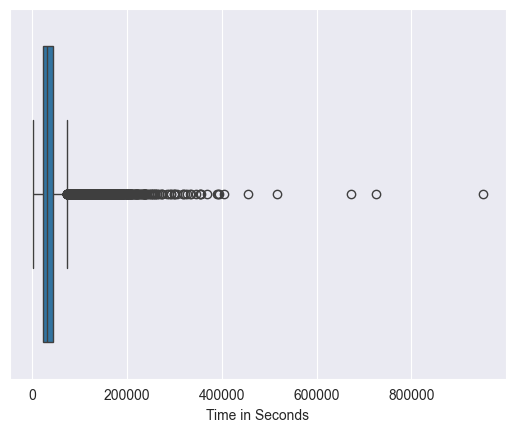

In [28]:
sns.boxplot(x=audible_data['Time in Seconds'])
plt.draw()

### Audiobook Languages

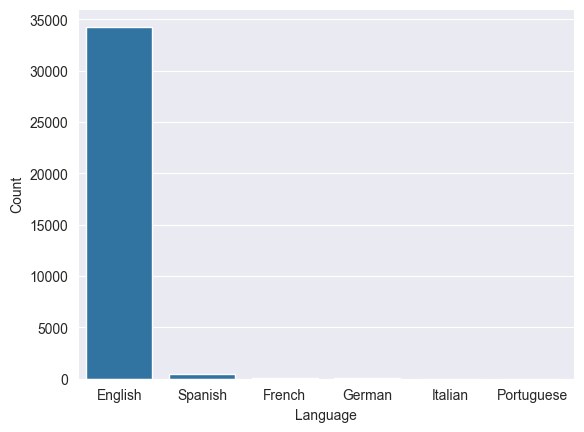

In [29]:
language_columns = [
    'Language_English',
    'Language_Spanish',
    'Language_French',
    'Language_German',
    'Language_Italian',
    'Language_Portuguese'
]
language_counts = audible_data[language_columns].sum()
sns.barplot(x=language_counts.index.str.replace('Language_', ''), y=language_counts.values)
plt.xlabel('Language')
plt.ylabel('Count')
plt.draw()

### Audiobook Stars

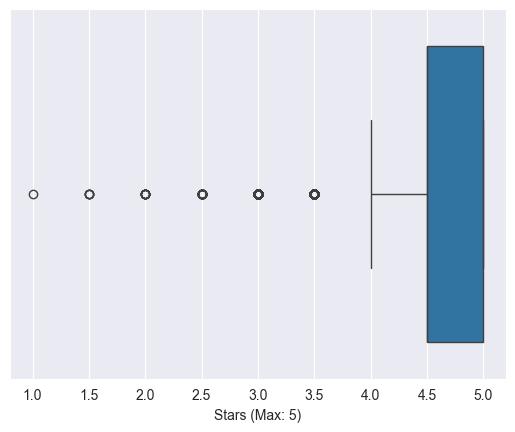

In [30]:
sns.boxplot(x=audible_data['Stars (Max: 5)'])
plt.draw()

### Audiobook Weighted Ratings

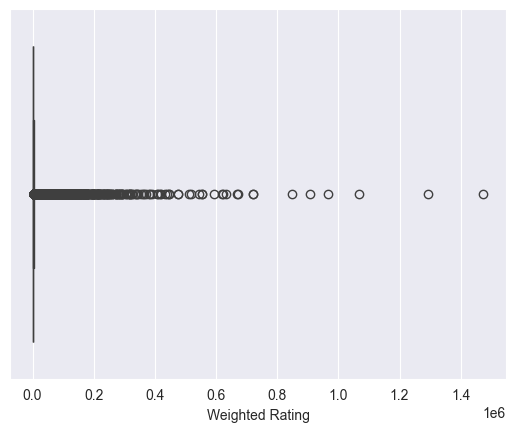

In [31]:
sns.boxplot(x=audible_data['Weighted Rating'])
plt.draw()

### Audiobook Prices

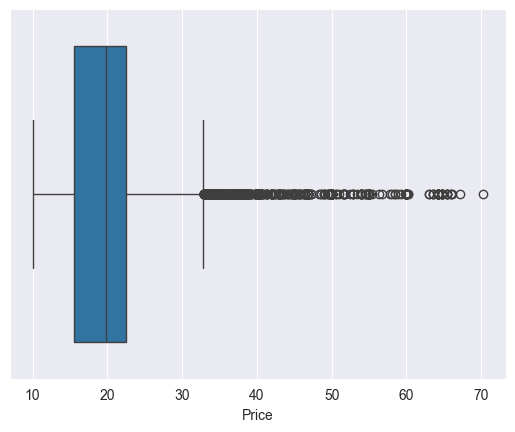

In [32]:
sns.boxplot(x=audible_data['Price'])
plt.draw()

### Conclusion

* The dataset consists of 34844 entries and 125 features.
* The plot for Audiobook Lengths is skewed right, having most audiobooks under 100000 seconds.  
  Several outliers indicate that some audiobooks are longer than the rest.  
* The plot for Audiobook Languages shows the majority of audiobooks are in English.
* The plot for Audiobook Stars is heavily skewed left with few outliers.  
* The plot for Audiobook Weighted Rating is heavily skewed right with many outliers.
* The plot for Audiobook Prices is skewed right, having most audiobook prices under 40.  
  Several outliers indicate that some audiobook prices fall into the range of 40 to 60, with a few higher than 60.

## Further Data Process Based on Dataset Characteristics

### Remove Length Outliers

In [33]:
print(f'Size of Dataset before Removing: {audible_data.shape}')
audible_data = audible_data[audible_data['Time in Seconds'] <= 300000]
print(f'Size of Dataset after Removing: {audible_data.shape}')

Size of Dataset before Removing: (34844, 15)
Size of Dataset after Removing: (34822, 15)


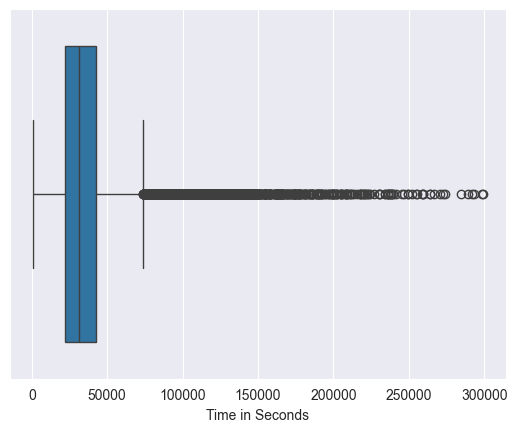

In [34]:
sns.boxplot(x=audible_data['Time in Seconds'])
plt.draw()

### Log Transformation for Weighted Ratings

As the weighted rating is heavily skewed to the right, applying a log transformation helps mitigate this skew.

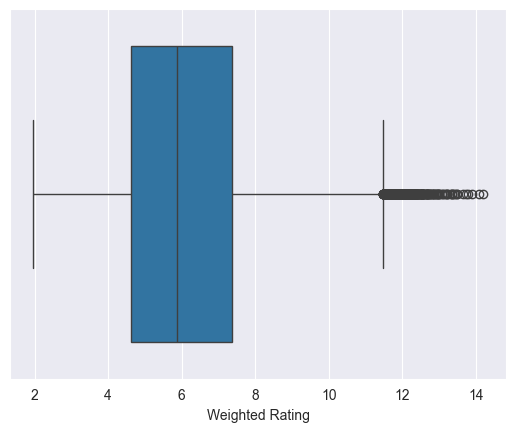

In [35]:
audible_data['Weighted Rating'] = np.log1p(audible_data['Weighted Rating'])
sns.boxplot(x=audible_data['Weighted Rating'])
plt.draw()

## Statistical Tests

### Audiobook Lengths vs. Prices

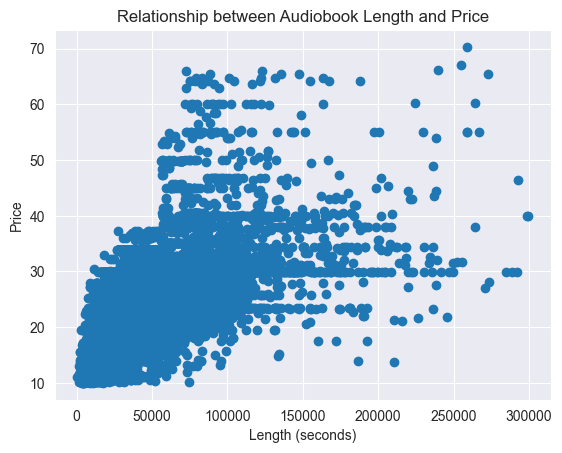

In [36]:
plt.scatter(audible_data['Time in Seconds'], audible_data['Price'])
plt.title('Relationship between Audiobook Length and Price')
plt.xlabel('Length (seconds)')
plt.ylabel('Price')
plt.draw()

In [37]:
_, p_value = pearsonr(audible_data['Time in Seconds'], audible_data['Price'])
p_value

0.0

### Audiobook Stars vs. Prices

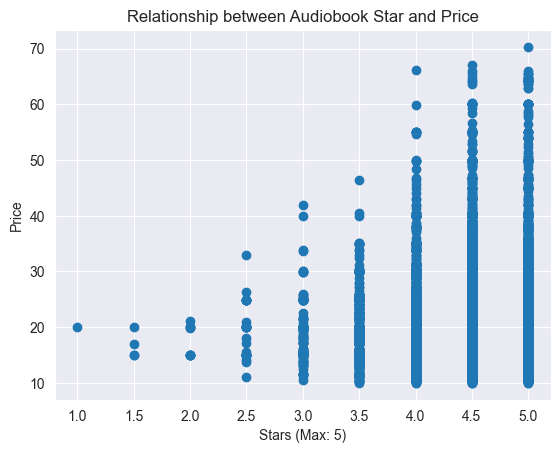

In [38]:
plt.scatter(audible_data['Stars (Max: 5)'], audible_data['Price'])
plt.title('Relationship between Audiobook Star and Price')
plt.xlabel('Stars (Max: 5)')
plt.ylabel('Price')
plt.draw()

In [39]:
rating_mean = audible_data['Stars (Max: 5)'].mean()
_, p_value = ttest_ind(
    audible_data[audible_data['Stars (Max: 5)'] < rating_mean]['Price'],
    audible_data[audible_data['Stars (Max: 5)'] >= rating_mean]['Price'],
    equal_var=False
)
p_value

7.595313288050364e-07

### Audiobook Weighted Ratings vs. Prices

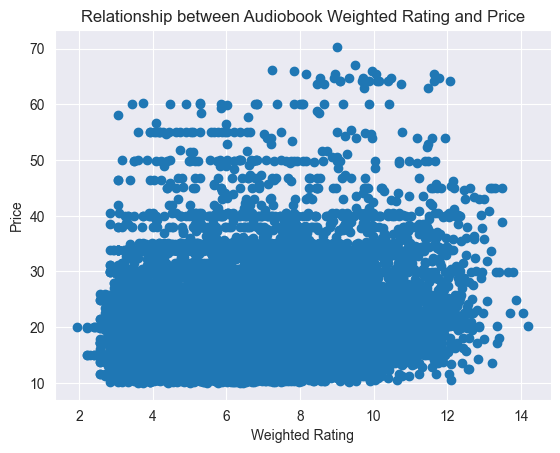

In [40]:
plt.scatter(audible_data['Weighted Rating'], audible_data['Price'])
plt.title('Relationship between Audiobook Weighted Rating and Price')
plt.xlabel('Weighted Rating')
plt.ylabel('Price')
plt.draw()

In [41]:
_, p_value = pearsonr(audible_data['Weighted Rating'], audible_data['Price'])
p_value

4.664858814107088e-207

### Conclusion

|      A[^1]      | B[^1]  | Test Type |  P-Value   | Reject/Fail to Reject[^2] | Correlation[^3] |
|:---------------:|:------:|:---------:|:----------:|:-------------------------:|:---------------:|
|     Length      | Price  |  Pearson  |    0.0     |          Reject           |       Yes       |
|      Star       | Price  |  T Test   |  7.595e-7  |          Reject           |       Yes       |
| Weighted Rating | Price  |  Pearson  | 4.665e-207 |          Reject           |       Yes       |
  
[^1]: A and B: This row investigate the relationship between A and B. With the following hypotheses:  
Null Hypothesis: There is no correlation between A and B.  
Alternative Hypothesis: There is a correlation between A and B.  
[^2]: Reject/Fail to Reject: Based on the P-Value, reject or fail to reject the Null Hypothesis.  
[^3]: Correlation: There is/is no correlation between A and B.

## Save Further Processed Dataset

In [42]:
audible_data = audible_data.filter(items=['Time in Seconds', 'Stars (Max: 5)', 'Weighted Rating', 'Price'])
audible_data.to_csv(data_folder + '/audible_further.csv', index=False)

<h1 style="text-align: center;">Primary Analysis</h1>

In [43]:
audible_data.head()

,Time in Seconds,Stars (Max: 5),Weighted Rating,Price
0,59580.0,4.5,10.27424,22.5
2,110700.0,4.0,2.833213,30.09
4,33480.0,4.5,5.666427,15.47
6,37740.0,4.5,6.741701,15.47
7,37080.0,4.5,8.351257,23.75


In [44]:
audible_data.describe(include='all')

,Time in Seconds,Stars (Max: 5),Weighted Rating,Price
count,34822.0,34822.0,34822.0,34822.0
mean,36033.213486,4.525745,6.121637,20.097827
std,24099.664767,0.37496,1.990786,5.947675
min,480.0,1.0,1.94591,10.0
25%,21780.0,4.5,4.615121,15.59
50%,31260.0,4.5,5.874931,19.79
75%,42660.0,5.0,7.357875,22.5
max,299460.0,5.0,14.203535,70.29


In [45]:
audible_data.dtypes

Time in Seconds    Float64
Stars (Max: 5)     Float64
Weighted Rating    Float64
Price              Float64
dtype: object

All of the feature data and the label are in Float64, meaning we are going to use numeric data to predict a numeric value. As a result, we will develop regressors with machine learning to predict prices.

## Prepare the Dataset

In [46]:
random_state = 42

### Split the Dataset into Training and Test Sets

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    audible_data[['Time in Seconds', 'Stars (Max: 5)', 'Weighted Rating']],
    audible_data['Price'], test_size=0.1, random_state=random_state
)

### Split the Training Set Further into Training and Validation Sets

In [48]:
X_train_further, X_valid, y_train_further, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

### Standardization

In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_further_scaled = scaler.fit_transform(X_train_further)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Create a Dict() to Store Model and Metrics

In [50]:
models = dict()
# {name: model, model_type, model_type_color, mse_test, r2_test, r2_valid}
show_metrics = lambda models_dict : sorted([(key, value[1:]) for key, value in models_dict.items()], key=lambda items: items[1][3], reverse=True)

## Train Models

In [51]:
def train(_model):
    _model.fit(X_train_further_scaled, y_train_further)
    r2_valid = r2_score(y_valid, _model.predict(X_valid_scaled))
    _y_pred = _model.predict(X_test_scaled)
    mse_test = mean_squared_error(y_test, _y_pred)
    r2_test = r2_score(y_test, _y_pred)
    return mse_test, r2_test, r2_valid

### K-Nearest Neighbors

In [52]:
models_local = dict()
for n in tqdm([3, 5, 10, 25, 50, 100, 250]):
    model = KNeighborsRegressor(n_neighbors=n)
    models_local[f'K-Nearest Neighbors with N = {n}'] = [model, 'K-Nearest', 'green', *train(model)]
models |= models_local
show_metrics(models_local)

100%|██████████| 7/7 [00:00<00:00,  9.67it/s]


[('K-Nearest Neighbors with N = 100',
  ['K-Nearest',
   'green',
   17.265296598825728,
   0.5171665214654109,
   0.5173467494425481]),
 ('K-Nearest Neighbors with N = 50',
  ['K-Nearest',
   'green',
   17.344936021866207,
   0.5149393613679853,
   0.5184000599812078]),
 ('K-Nearest Neighbors with N = 250',
  ['K-Nearest',
   'green',
   17.400004180538613,
   0.5133993501404862,
   0.5116008389361979]),
 ('K-Nearest Neighbors with N = 25',
  ['K-Nearest',
   'green',
   17.602209736388172,
   0.5077445609886739,
   0.5125936967352959]),
 ('K-Nearest Neighbors with N = 10',
  ['K-Nearest',
   'green',
   18.636439495549812,
   0.47882175914963865,
   0.4810346649512155]),
 ('K-Nearest Neighbors with N = 5',
  ['K-Nearest',
   'green',
   19.96175402583979,
   0.44175861220921087,
   0.44735685923979684]),
 ('K-Nearest Neighbors with N = 3',
  ['K-Nearest',
   'green',
   22.145649660254566,
   0.38068477430058756,
   0.38979590795538255])]

### Linear Regression

In [53]:
models_local = dict()
model = LinearRegression()
models_local['Linear Regression'] = [model, 'Regression', 'cyan', *train(model)]
models |= models_local
show_metrics(models_local)

[('Linear Regression',
  ['Regression',
   'cyan',
   19.457258048269267,
   0.4558671186204851,
   0.4348573013351428])]

### Polynomial Regressions

In [54]:
models_local = dict()
# grid search for best regressor and degree
for name, regressor in tqdm([
    ('Polynomial Regression', LinearRegression()),
    ('Lasso Regression', Lasso(alpha=0.01, max_iter=5000)),
    ('Ridge Regression', Ridge(alpha=0.01, max_iter=5000)),
    ('Elastic Net', ElasticNet(alpha=0.01, max_iter=5000)),
    ('Bayesian ARD Regression', ARDRegression()),
    ('Bayesian Ridge Regression', BayesianRidge())
]):
    for degree in range(2, 5):
        model = make_pipeline(PolynomialFeatures(degree), regressor)
        models_local[f'{name} with Degree {degree}'] = [model, 'Regression', 'cyan', *train(model)]
models |= models_local
show_metrics(models_local)

100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


[('Bayesian ARD Regression with Degree 4',
  ['Regression',
   'cyan',
   17.416950322806137,
   0.5129254419876819,
   0.5107273434570418]),
 ('Lasso Regression with Degree 3',
  ['Regression',
   'cyan',
   17.425383043873627,
   0.5126896163229895,
   0.5097765144362387]),
 ('Bayesian ARD Regression with Degree 3',
  ['Regression',
   'cyan',
   17.426279670049812,
   0.5126645416807373,
   0.5101841606331945]),
 ('Elastic Net with Degree 3',
  ['Regression',
   'cyan',
   17.43163350897638,
   0.5125148186419449,
   0.5095674876867979]),
 ('Bayesian Ridge Regression with Degree 3',
  ['Regression',
   'cyan',
   17.433877005843435,
   0.5124520780229117,
   0.5101314842309064]),
 ('Ridge Regression with Degree 3',
  ['Regression',
   'cyan',
   17.434062333976932,
   0.5124468952201227,
   0.5101579804972567]),
 ('Polynomial Regression with Degree 3',
  ['Regression',
   'cyan',
   17.434062514844936,
   0.5124468901620498,
   0.5101580038648863]),
 ('Lasso Regression with Degree 2

In [55]:
best_poly_degree = 3

### Support Vector Machine (SVM)

In [56]:
models_local = dict()
# grid search for best kernel and C
for kernel in tqdm(['linear', 'poly', 'rbf']):
    for C in [0.01, 0.1, 1, 10]:
        model = SVR(kernel=kernel, C=C, degree=best_poly_degree)
        models_local[f'Support Vector Machine with {kernel} kernel and C = {C}'] = [model, 'SVM', 'blue', *train(model)]
models |= models_local
show_metrics(models_local)

100%|██████████| 3/3 [04:35<00:00, 91.74s/it] 


[('Support Vector Machine with rbf kernel and C = 1',
  ['SVM', 'blue', 17.792408451528708, 0.5024255497154844, 0.5016784641749399]),
 ('Support Vector Machine with rbf kernel and C = 10',
  ['SVM', 'blue', 17.85302173152824, 0.5007304661320633, 0.503827520786478]),
 ('Support Vector Machine with rbf kernel and C = 0.1',
  ['SVM',
   'blue',
   18.628584980643733,
   0.47904141496224495,
   0.4810615640030459]),
 ('Support Vector Machine with linear kernel and C = 0.01',
  ['SVM', 'blue', 19.99852227522114, 0.4407303679710186, 0.41406092371931913]),
 ('Support Vector Machine with linear kernel and C = 0.1',
  ['SVM', 'blue', 20.07160925507066, 0.43868645053731925, 0.4118414095843328]),
 ('Support Vector Machine with linear kernel and C = 1',
  ['SVM',
   'blue',
   20.083798429353546,
   0.43834557360040804,
   0.4114733466753454]),
 ('Support Vector Machine with linear kernel and C = 10',
  ['SVM',
   'blue',
   20.084621971327977,
   0.4383225427978986,
   0.41145032226219447]),
 ('S

### Decision Tree

In [57]:
models_local = dict()
model = DecisionTreeRegressor(random_state=random_state)
models_local['Decision Tree'] = [model, 'Decision Tree', 'pink', *train(model)]
models |= models_local
show_metrics(models_local)

[('Decision Tree',
  ['Decision Tree',
   'pink',
   35.28473132676173,
   0.013243156980142667,
   0.04929894078944308])]

### Random Forest

In [58]:
models_local = dict()
for n_estimators in tqdm([100, 250, 500, 1000]):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    models_local[f'Random Forest with {n_estimators} Estimators'] = [model, 'Random Forest', 'purple', *train(model)]
models |= models_local
show_metrics(models_local)

100%|██████████| 4/4 [01:22<00:00, 20.68s/it]


[('Random Forest with 1000 Estimators',
  ['Random Forest',
   'purple',
   19.96406417682228,
   0.4416940075713218,
   0.4424888880542225]),
 ('Random Forest with 500 Estimators',
  ['Random Forest',
   'purple',
   19.98665576728515,
   0.4410622213667593,
   0.43910607923561407]),
 ('Random Forest with 250 Estimators',
  ['Random Forest',
   'purple',
   20.049082896403814,
   0.43931641249896725,
   0.4359208978188984]),
 ('Random Forest with 100 Estimators',
  ['Random Forest',
   'purple',
   20.23745546420591,
   0.43404847043658956,
   0.4326912754556158])]

## Ensemble

### Gather Models to Ensemble

Find the best models for each model types.

In [59]:
best_models = dict()
best_models_with_r2 = dict()
for model_name, model_info in models.items():
    model_type = model_info[1]
    model_r2_valid = model_info[5]
    if model_type not in best_models_with_r2 or model_r2_valid > best_models_with_r2[model_type]:
        best_models_with_r2[model_type] = model_r2_valid
        best_models[model_type] = model_info[0]
best_models

{'K-Nearest': KNeighborsRegressor(n_neighbors=50),
 'Regression': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                 ('linearregression', LinearRegression())]),
 'SVM': SVR(C=10),
 'Decision Tree': DecisionTreeRegressor(random_state=42),
 'Random Forest': RandomForestRegressor(n_estimators=1000, random_state=42)}

In [60]:
best_models.pop('Decision Tree')
best_models.pop('Random Forest')
best_models

{'K-Nearest': KNeighborsRegressor(n_neighbors=50),
 'Regression': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                 ('linearregression', LinearRegression())]),
 'SVM': SVR(C=10)}

In [61]:
class Ensemble:
    def __init__(self, _models, method):
        self.models = _models
        self.method = method
    
    def fit(self, _X, _y):
        for _model in self.models:
            _model.fit(_X, _y)
        return self
    
    def predict(self, _X):
        _y_pred = np.array([_model.predict(_X) for _model in self.models])
        return np.mean(_y_pred, axis=0) if self.method == 'Averaging' \
            else  np.apply_along_axis(lambda row: Counter(row).most_common(1)[0][0], axis=0, arr=_y_pred)  # else voting ensemble

### Averaging Ensemble

In [62]:
models_local = dict()
model = Ensemble(_models=best_models.values(), method='Averaging')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
models_local['Averaging Ensemble'] = [model, 'Ensemble', 'orange', mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), np.nan]
models |= models_local
show_metrics(models_local)

[('Averaging Ensemble',
  ['Ensemble', 'orange', 17.278836205061758, 0.5167878789590681, nan])]

### Voting Ensemble

In [63]:
models_local = dict()
model = Ensemble(_models=best_models.values(), method='Voting')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
models_local['Voting Ensemble'] = [model, 'Ensemble', 'orange', mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), np.nan]
models |= models_local
show_metrics(models_local)

[('Voting Ensemble',
  ['Ensemble', 'orange', 17.25880560465116, 0.5173480456737275, nan])]

<h1 style="text-align: center;">Result Visualization</h1>

## Gather Metrics

In [64]:
metrics = show_metrics(models)
model_names = [x[0] for x in metrics]
model_types = [x[1][0] for x in metrics]
model_type_colors = [x[1][1] for x in metrics]
mse_values = [x[1][2] for x in metrics]
r2_values = [x[1][3] for x in metrics]
metrics

[('Voting Ensemble',
  ['Ensemble', 'orange', 17.25880560465116, 0.5173480456737275, nan]),
 ('K-Nearest Neighbors with N = 100',
  ['K-Nearest',
   'green',
   17.265296598825728,
   0.5171665214654109,
   0.5173467494425481]),
 ('Averaging Ensemble',
  ['Ensemble', 'orange', 17.278836205061758, 0.5167878789590681, nan]),
 ('K-Nearest Neighbors with N = 50',
  ['K-Nearest',
   'green',
   17.344936021866207,
   0.5149393613679853,
   0.5184000599812078]),
 ('K-Nearest Neighbors with N = 250',
  ['K-Nearest',
   'green',
   17.400004180538613,
   0.5133993501404862,
   0.5116008389361979]),
 ('Bayesian ARD Regression with Degree 4',
  ['Regression',
   'cyan',
   17.416950322806137,
   0.5129254419876819,
   0.5107273434570418]),
 ('Lasso Regression with Degree 3',
  ['Regression',
   'cyan',
   17.425383043873627,
   0.5126896163229895,
   0.5097765144362387]),
 ('Bayesian ARD Regression with Degree 3',
  ['Regression',
   'cyan',
   17.426279670049812,
   0.5126645416807373,
   0.510

## Plot

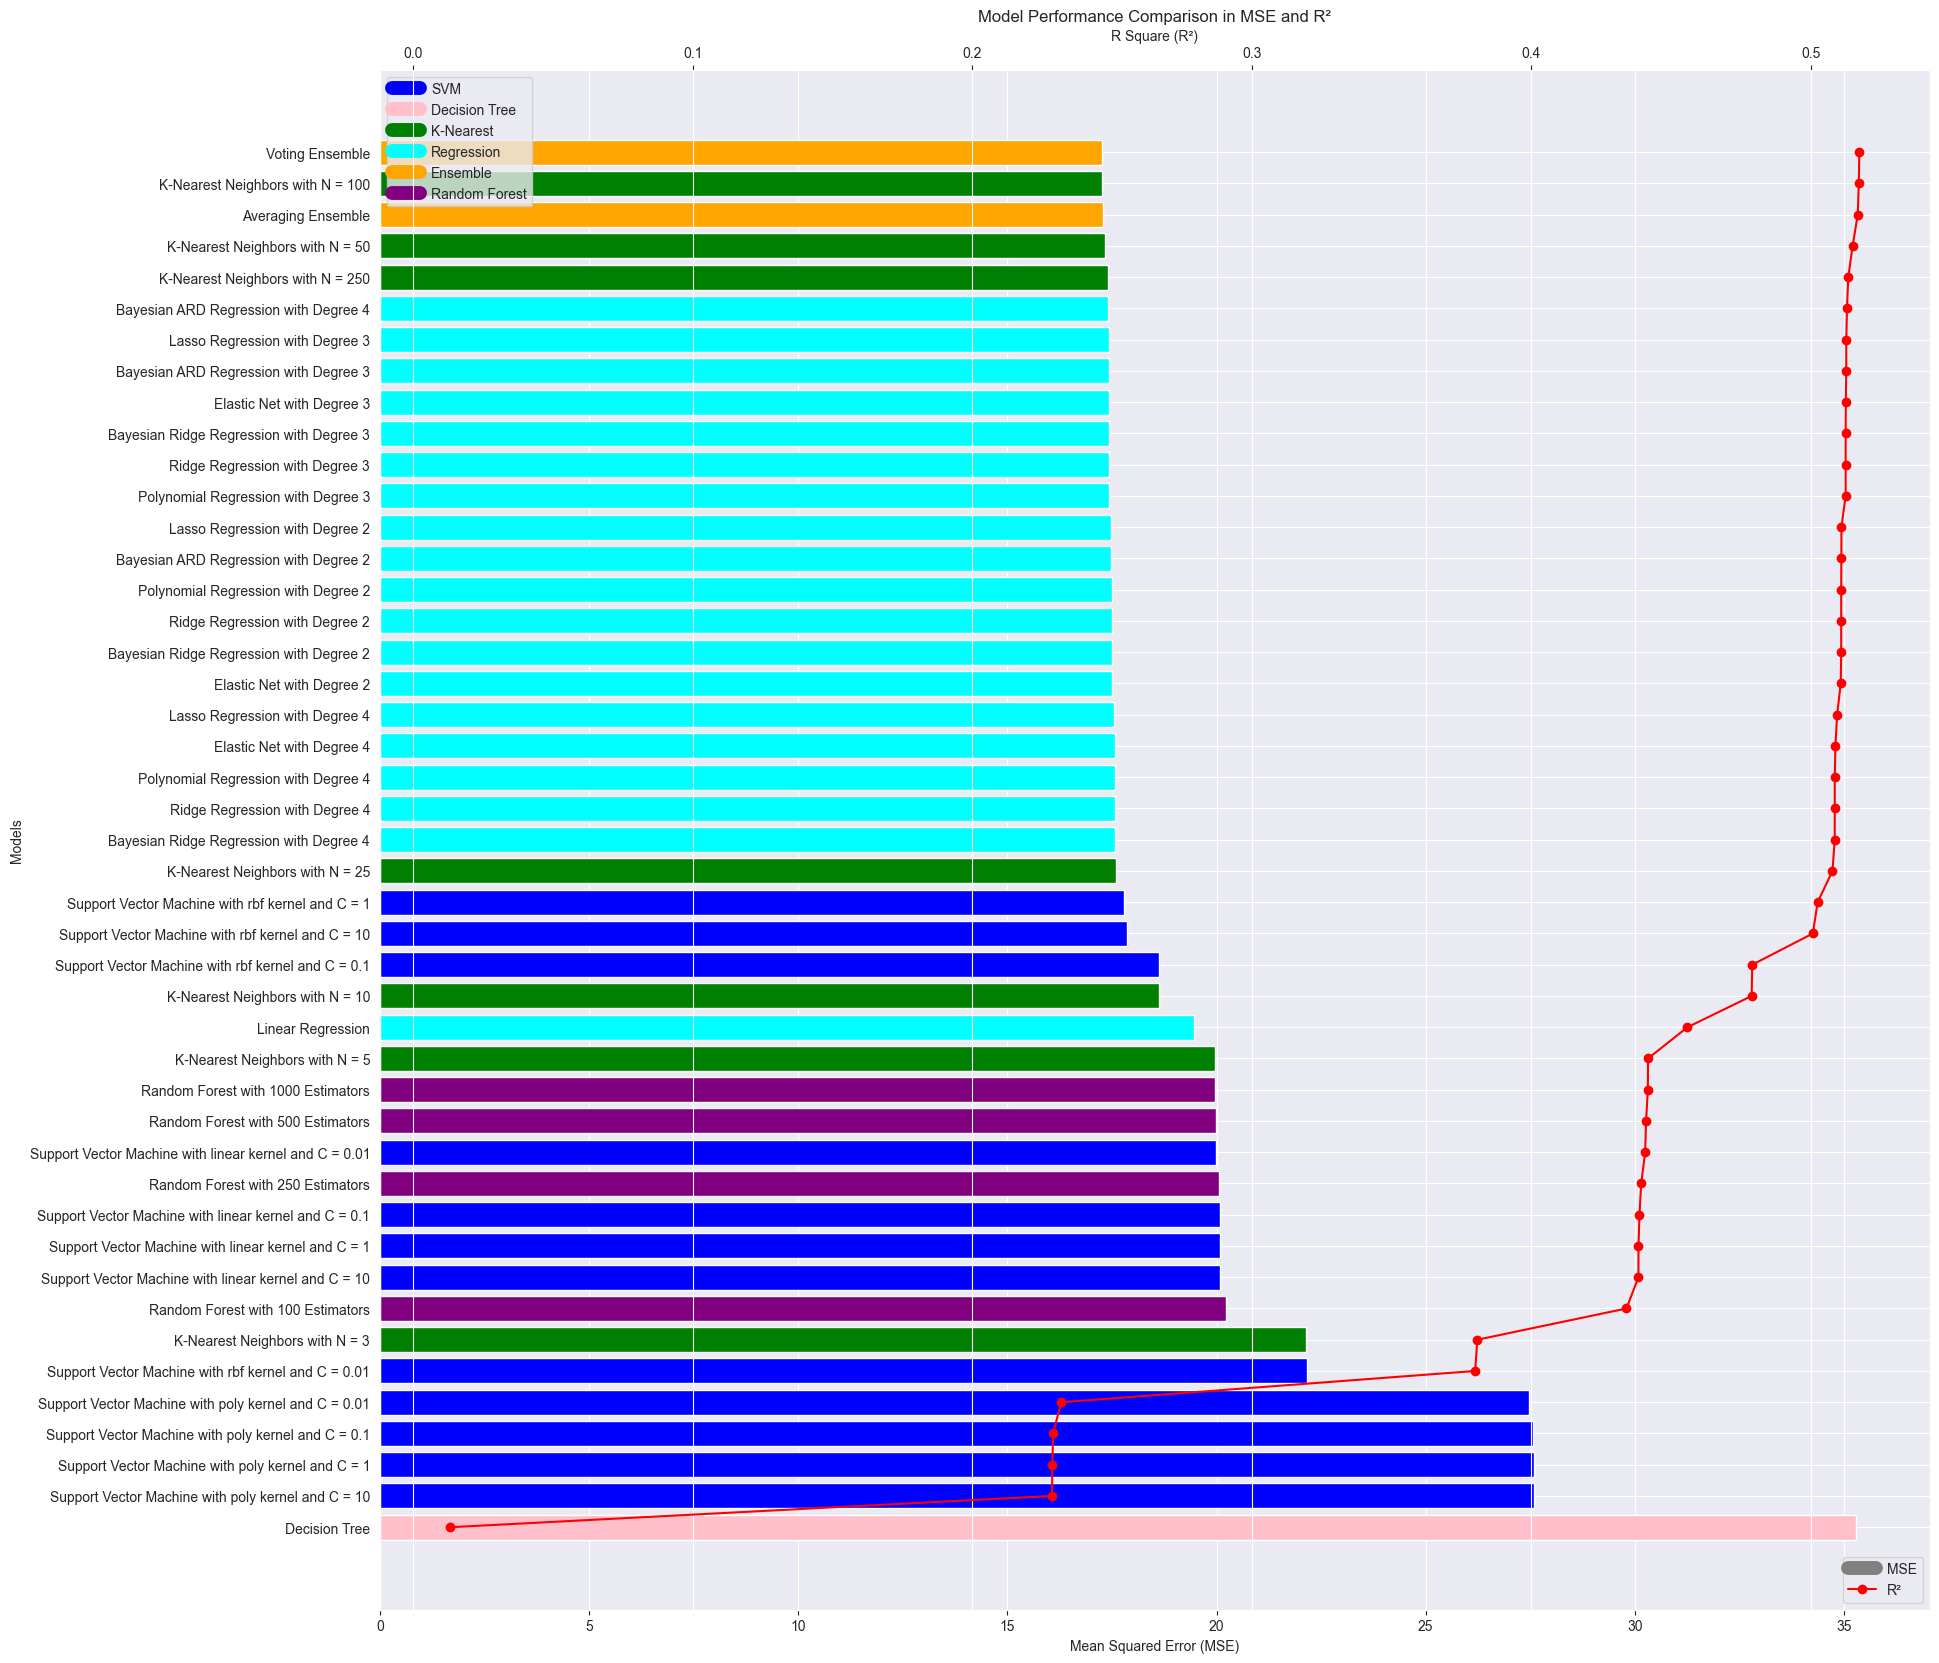

In [65]:
_, ax1 = plt.subplots(figsize=(20, 20))

# MSEs
ax1.barh(model_names, mse_values, color=model_type_colors)
ax1.set_xlabel('Mean Squared Error (MSE)')
ax1.set_ylabel('Models')
ax1.invert_yaxis()

# R-Squares
ax2 = ax1.twiny()
line, = ax2.plot(r2_values, model_names, 'o-', color='r')
ax2.set_xlabel('R Square (R²)')

# legend for model types
handles, labels = list(), list()
for model_type, type_color in set(zip(model_types, model_type_colors)):
    handles.append(plt.Line2D([0], [0], color=type_color, lw=10))
    labels.append(model_type)
ax1.legend(handles=handles, labels=labels, loc='upper left')

# legend for metrics
ax2.legend(
    handles=[plt.Line2D([0], [0], color='grey', lw=10), line],
    labels=['MSE', 'R²'], loc='lower right'
)

plt.title('Model Performance Comparison in MSE and R²')
plt.draw()

<h1 style="text-align: center;">Insights and Conclusions</h1>

### About Audiobook

* Most audiobooks are under 100,000 seconds (27.7 hours), but a few are much longer.  
* In the U.S., Audible's most popular audiobooks are in English, with Spanish being the second most common language.  
* Audiobooks tend to have high star ratings. It suggests the customers are mostly satisfied.  
* Audiobook prices are mainly under 40 dollars, with some between 40 and 60 and a few beyond 60 dollars.

### About Correlations between Prices and Other Features

* There is a positive correlation between audiobook lengths and prices as long as the audiobook is not too much lengthy.
* The relationship between audiobook ratings and prices is weak, but higher-rated audiobooks still tend to have a higher price.

### About Applied Machine Learning Techniques

* The result of machine learning techniques is not ideal. Most of the models result in a $R^2$ score of around 50.
* K-Nearest Neighbors and Polynomial Regressions performed very well compared to other models.
* Voting Ensemble pushed the performance further, resulting in a best $R^2$ score of 0.517.